In [ ]:
from config import set_project_root

set_project_root(levels_up=4)

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [16]:
tickers = [
    "AAPL",  # Apple Inc. (Technology)
    "MSFT",  # Microsoft Corporation (Technology)
    "GOOGL",  # Alphabet Inc. (Technology)
    "AMZN",  # Amazon.com Inc. (Consumer Discretionary)
    "TSLA",  # Tesla Inc. (Consumer Discretionary)
    "META",  # Meta Platforms Inc. (Communication Services)
    "NFLX",  # Netflix Inc. (Communication Services)
    "NVDA",  # NVIDIA Corporation (Technology)
    "JPM",  # JPMorgan Chase & Co. (Financials)
    "V",  # Visa Inc. (Financials)
    "MA",  # Mastercard Incorporated (Financials)
    "JNJ",  # Johnson & Johnson (Healthcare)
    "UNH",  # UnitedHealth Group Incorporated (Healthcare)
    "PFE",  # Pfizer Inc. (Healthcare)
    "MRK",  # Merck & Co., Inc. (Healthcare)
    "XOM",  # Exxon Mobil Corporation (Energy)
    "CVX",  # Chevron Corporation (Energy)
    "WMT",  # Walmart Inc. (Consumer Staples)
    "KO",  # The Coca-Cola Company (Consumer Staples)
    "PEP",  # PepsiCo Inc. (Consumer Staples)
    "T",  # AT&T Inc. (Telecommunications)
    "VZ",  # Verizon Communications Inc. (Telecommunications)
    "DIS",  # The Walt Disney Company (Communication Services)
    "NKE",  # Nike Inc. (Consumer Discretionary)
    "ADBE",  # Adobe Inc. (Technology)
    "INTC",  # Intel Corporation (Technology)
    "CSCO",  # Cisco Systems Inc. (Technology)
    "BA",  # Boeing Co. (Industrials)
    "CAT",  # Caterpillar Inc. (Industrials)
    "MMM",  # 3M Company (Industrials)
    "MDT",  # Medtronic plc (Healthcare)
    "LMT",  # Lockheed Martin Corporation (Aerospace & Defense)
    "TMO",  # Thermo Fisher Scientific Inc. (Healthcare)
    "AMGN",  # Amgen Inc. (Healthcare)
    "TXN",  # Texas Instruments Incorporated (Technology)
    "QCOM",  # Qualcomm Incorporated (Technology)
    "LRCX",  # Lam Research Corporation (Technology)
    "SBUX",  # Starbucks Corporation (Consumer Discretionary)
    "CHTR",  # Charter Communications Inc. (Communication Services)
    "SPGI",  # S&P Global Inc. (Financials)
    "NOW",  # ServiceNow Inc. (Technology)
    "ZM",  # Zoom Video Communications, Inc. (Communication Services)
    "VRTX",  # Vertex Pharmaceuticals Incorporated (Healthcare)
    "BIIB",  # Biogen Inc. (Healthcare)
    "GILD",  # Gilead Sciences Inc. (Healthcare)
    "NVS",  # Novartis AG (Healthcare)
    "AZN",  # AstraZeneca plc (Healthcare)
    "HSY",  # The Hershey Company (Consumer Staples)
    "MCD",  # McDonald's Corporation (Consumer Discretionary)
    "CPB",  # Campbell Soup Company (Consumer Staples)
    "AMAT",  # Applied Materials, Inc. (Technology)
    "KMB",  # Kimberly-Clark Corporation (Consumer Staples)
]

In [17]:
# Create initial dataframe

start = "2022-09-30"

df = yf.download(tickers, start)

df = df.stack().reset_index()

columns = {column: column.replace(" ", "_").lower() for column in df.columns}

df = df.rename(columns=columns)

df = df.sort_values(["ticker", "date"])

df = df.reset_index(drop=True)

df

[*********************100%***********************]  52 of 52 completed
/var/folders/5k/s9c0d19s0k7byf19zlnzgmjr0000gn/T/ipykernel_13080/3730181472.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,date,ticker,adj_close,close,high,low,open,volume
0,2022-09-30 00:00:00+00:00,AAPL,136.535339,138.199997,143.100006,138.000000,141.279999,124925300.0
1,2022-10-03 00:00:00+00:00,AAPL,140.734131,142.449997,143.070007,137.690002,138.210007,114311700.0
2,2022-10-04 00:00:00+00:00,AAPL,144.340179,146.100006,146.220001,144.259995,145.029999,87830100.0
3,2022-10-05 00:00:00+00:00,AAPL,144.636520,146.399994,147.380005,143.009995,144.070007,79471000.0
4,2022-10-06 00:00:00+00:00,AAPL,143.678253,145.429993,147.539993,145.220001,145.809998,68402200.0
...,...,...,...,...,...,...,...,...
27864,2024-11-11 00:00:00+00:00,ZM,85.580002,85.580002,86.230003,81.830002,81.870003,5447400.0
27865,2024-11-12 00:00:00+00:00,ZM,86.320000,86.320000,87.099998,84.070000,84.730003,3943000.0
27866,2024-11-13 00:00:00+00:00,ZM,85.040001,85.040001,87.144997,84.650002,86.510002,2729000.0
27867,2024-11-14 00:00:00+00:00,ZM,82.629997,82.629997,84.889999,82.400002,84.870003,2905700.0


In [18]:
# Generate features

df["ret"] = df.groupby("ticker")["adj_close"].pct_change()
df["log_ret"] = np.log(1 + df["ret"])

for t in [50, 100, 150]:
    df[f"ret_{t}"] = (
        df.groupby("ticker")["log_ret"].rolling(t, t).sum().reset_index(drop=True)
    )
    df[f"ret_{t}"] = df.groupby("ticker")[f"ret_{t}"].shift(1)

df = df.dropna().reset_index(drop=True)

df

Price,date,ticker,adj_close,close,high,low,open,volume,ret,log_ret,ret_50,ret_100,ret_150
0,2023-05-09 00:00:00+00:00,AAPL,170.242020,171.770004,173.539993,171.600006,173.050003,45326900.0,-0.009971,-0.010021,0.167720,0.184493,0.230659
1,2023-05-10 00:00:00+00:00,AAPL,172.016083,173.559998,174.029999,171.899994,173.020004,53724500.0,0.010421,0.010367,0.149485,0.167712,0.190349
2,2023-05-11 00:00:00+00:00,AAPL,172.204407,173.750000,174.589996,172.169998,173.850006,49514700.0,0.001095,0.001094,0.163305,0.193737,0.175415
3,2023-05-12 00:00:00+00:00,AAPL,171.271469,172.570007,174.059998,171.000000,173.619995,45497800.0,-0.005418,-0.005432,0.178748,0.242819,0.174458
4,2023-05-15 00:00:00+00:00,AAPL,170.775223,172.070007,173.210007,171.470001,173.160004,37266700.0,-0.002897,-0.002902,0.169195,0.252072,0.175673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20012,2024-11-11 00:00:00+00:00,ZM,85.580002,85.580002,86.230003,81.830002,81.870003,5447400.0,0.050577,0.049340,0.152474,0.371017,0.256819
20013,2024-11-12 00:00:00+00:00,ZM,86.320000,86.320000,87.099998,84.070000,84.730003,3943000.0,0.008647,0.008610,0.214186,0.383678,0.292915
20014,2024-11-13 00:00:00+00:00,ZM,85.040001,85.040001,87.144997,84.650002,86.510002,2729000.0,-0.014829,-0.014940,0.226422,0.382560,0.327385
20015,2024-11-14 00:00:00+00:00,ZM,82.629997,82.629997,84.889999,82.400002,84.870003,2905700.0,-0.028340,-0.028749,0.220824,0.385960,0.307635


In [19]:
pivot = df[["date", "ticker", "ret"]]
pivot = pivot.pivot(index="date", columns="ticker", values="ret")
pivot = pivot.dropna(axis=1, how="any")  # Get rid of stocks that are too young

columns = pivot.columns

scaler = StandardScaler()
scaled_pivot = scaler.fit_transform(pivot)
scaled_pivot = pd.DataFrame(columns=columns, data=scaled_pivot)

mse_matrix = pd.DataFrame(index=columns, columns=columns)


def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


for a in columns:
    for b in columns:
        mse = compute_mse(scaled_pivot[a], scaled_pivot[b])
        mse_matrix.loc[a, b] = mse

mse_matrix = mse_matrix.astype(float)

mse_matrix.head()

ticker,AAPL,ADBE,AMAT,AMGN,AMZN,AZN,BA,CAT,CHTR,CPB,...,T,TMO,TSLA,TXN,UNH,V,VRTX,WMT,XOM,ZM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,1.405390,1.252169,1.720922,1.329857,1.698401,1.635345,1.612717,1.802322,2.146595,...,2.116708,1.725168,1.315373,1.308775,2.036369,1.582093,1.621777,1.855094,2.088794,1.548904
ADBE,1.405390,0.000000,1.311764,1.775433,1.089774,1.916181,1.845678,1.674021,1.681550,2.168213,...,2.201993,1.681770,1.588677,1.458523,1.939527,1.376478,1.749025,1.858166,2.118562,1.387738
AMAT,1.252169,1.311764,0.000000,1.725274,1.169358,1.950197,1.579660,1.281191,1.804759,2.442984,...,2.419219,1.627256,1.307162,0.744297,2.074541,1.646889,1.773923,2.004184,2.035069,1.586561
AMGN,1.720922,1.775433,1.725274,0.000000,1.734830,1.633766,1.851444,1.570056,1.537580,1.784378,...,1.679078,1.398414,1.778722,1.605482,1.757815,1.685672,1.377694,1.676069,1.838252,1.929408
AMZN,1.329857,1.089774,1.169358,1.734830,0.000000,1.944176,1.544137,1.488579,1.842109,2.322588,...,2.138305,1.697176,1.374335,1.377525,2.092364,1.464467,1.740207,1.660425,2.166418,1.474943


In [20]:
corr = pivot.corr()

corr.head()

ticker,AAPL,ADBE,AMAT,AMGN,AMZN,AZN,BA,CAT,CHTR,CPB,...,T,TMO,TSLA,TXN,UNH,V,VRTX,WMT,XOM,ZM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.297305,0.373915,0.139539,0.335071,0.150800,0.182327,0.193641,0.098839,-0.073297,...,-0.058354,0.137416,0.342314,0.345613,-0.018184,0.208953,0.189112,0.072453,-0.044397,0.225548
ADBE,0.297305,1.000000,0.344118,0.112283,0.455113,0.041910,0.077161,0.162989,0.159225,-0.084106,...,-0.100997,0.159115,0.205662,0.270738,0.030237,0.311761,0.125487,0.070917,-0.059281,0.306131
AMAT,0.373915,0.344118,1.000000,0.137363,0.415321,0.024901,0.210170,0.359404,0.097620,-0.221492,...,-0.209609,0.186372,0.346419,0.627851,-0.037270,0.176555,0.113039,-0.002092,-0.017535,0.206719
AMGN,0.139539,0.112283,0.137363,1.000000,0.132585,0.183117,0.074278,0.214972,0.231210,0.107811,...,0.160461,0.300793,0.110639,0.197259,0.121092,0.157164,0.311153,0.161966,0.080874,0.035296
AMZN,0.335071,0.455113,0.415321,0.132585,1.000000,0.027912,0.227931,0.255710,0.078946,-0.161294,...,-0.069153,0.151412,0.312833,0.311238,-0.046182,0.267766,0.129896,0.169787,-0.083209,0.262528


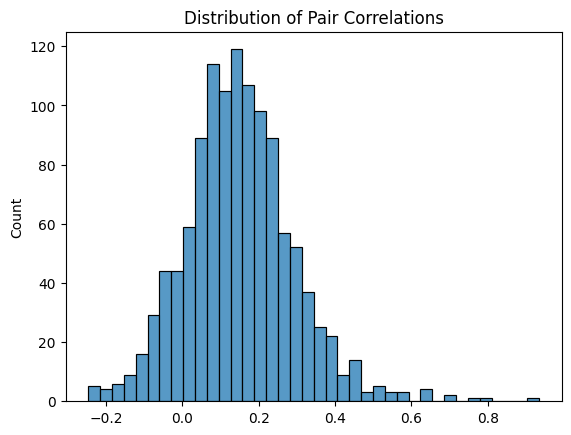

In [21]:
tri = np.triu(corr)

vals = tri[np.nonzero(tri)]
vals = vals[vals != 1]

sns.histplot(vals)
plt.title("Distribution of Pair Correlations")
plt.show()

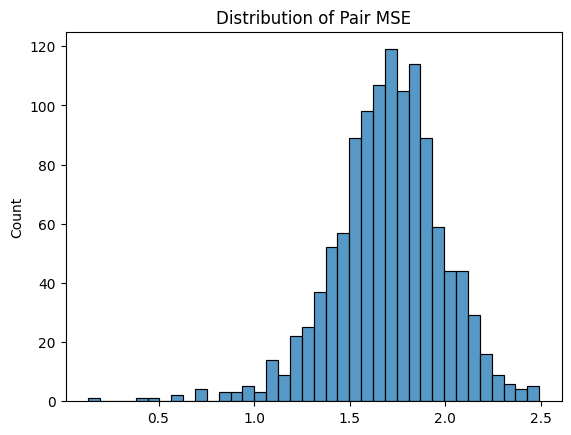

In [22]:
tri = np.triu(mse_matrix)

vals = tri[np.nonzero(tri)]
vals = vals[vals != 1]

sns.histplot(vals)
plt.title("Distribution of Pair MSE")
plt.show()

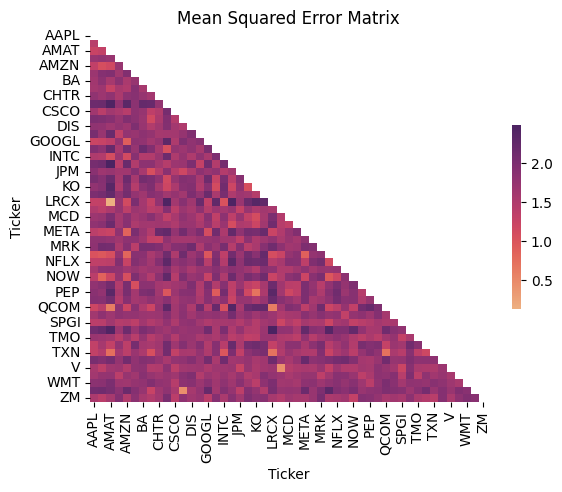

In [23]:
mask = np.triu(np.ones_like(mse_matrix, dtype=bool))

sns.heatmap(mse_matrix, mask=mask, cmap="flare", cbar_kws={"shrink": 0.5})
plt.title("Mean Squared Error Matrix")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.show()

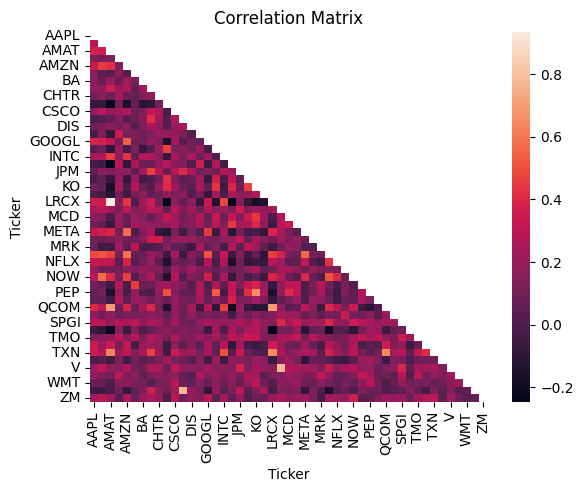

In [24]:
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask)
plt.title("Correlation Matrix")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.show()

In [25]:
# Clustering
# The aggregate dataframe represents the last day of the df dataframe

aggregate = df.groupby("ticker").agg(
    {"ret_50": "last", "ret_100": "last", "ret_150": "last"}
)

aggregate.head()

Price,ret_50,ret_100,ret_150
ticker,,,
AAPL,0.027022,0.089897,0.260318
ADBE,-0.069366,0.005659,0.111235
AMAT,0.031457,-0.228813,-0.107382
AMGN,-0.091731,-0.069101,0.115842
AMZN,0.172965,0.126557,0.127685


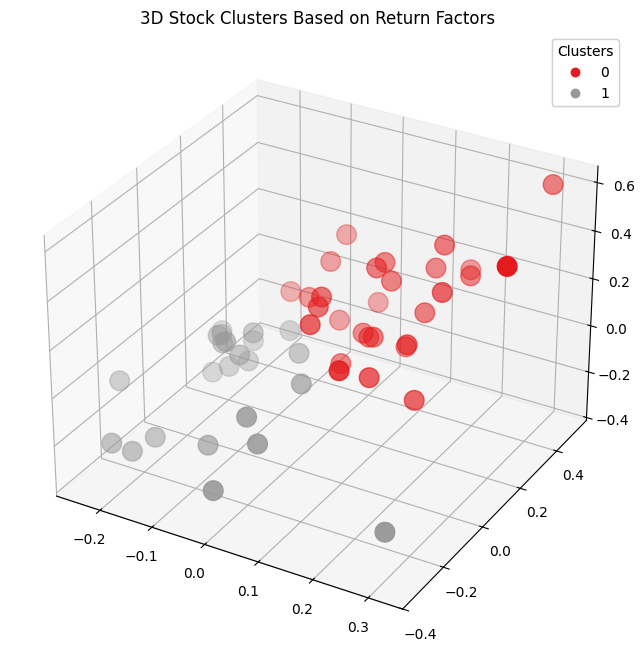

In [26]:
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()
scaled_data = scaler.fit_transform(aggregate)

n_clusters = 2  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters)
aggregate["Cluster"] = kmeans.fit_predict(scaled_data)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(
    aggregate["ret_50"],
    aggregate["ret_100"],
    aggregate["ret_150"],
    c=aggregate["Cluster"],
    s=200,
    cmap="Set1",
)

ax.set_title("3D Stock Clusters Based on Return Factors")
# ax.set_xlabel('50 Day Return')
# ax.set_ylabel('100 Day Return')
# ax.set_zlabel('150 Day Return')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()